<a href="https://colab.research.google.com/github/RafaelTorresCH/Signal-theory/blob/main/class%20notebooks/class_08_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparación entre la respuesta en frecuencia de un filtro y la densidad espectral de la salida

En teoría de señales, cuando una señal $ x(t) $ pasa por un **Sistema Lineal e Invariante en el Tiempo (SLIT)** con respuesta en frecuencia $ H(f) $, la **densidad espectral de potencia (o energía) de la salida** se relaciona con la del filtro mediante:

$$
S_{yy}(f) = |H(f)|^2 \cdot S_{xx}(f)
$$

Si la señal de entrada es **ruido blanco**, entonces $ S_{xx}(f) \approx \text{constante} $, y por lo tanto:

$$
S_{yy}(f) \propto |H(f)|^2
$$

En escala logarítmica (dB):
- $ 20 \log_{10} |H(f)| $ → respuesta del filtro (magnitud de voltaje),
- $ 10 \log_{10} S_{yy}(f) \propto 20 \log_{10} |H(f)| $ → espectro de salida.

Esto implica que **ambas curvas deben tener la misma forma**. Para compararlas visualmente, las **normalizamos a 0 dB** (es decir, restamos su valor máximo), de modo que ambas partan desde 0 dB en su punto de mayor ganancia.


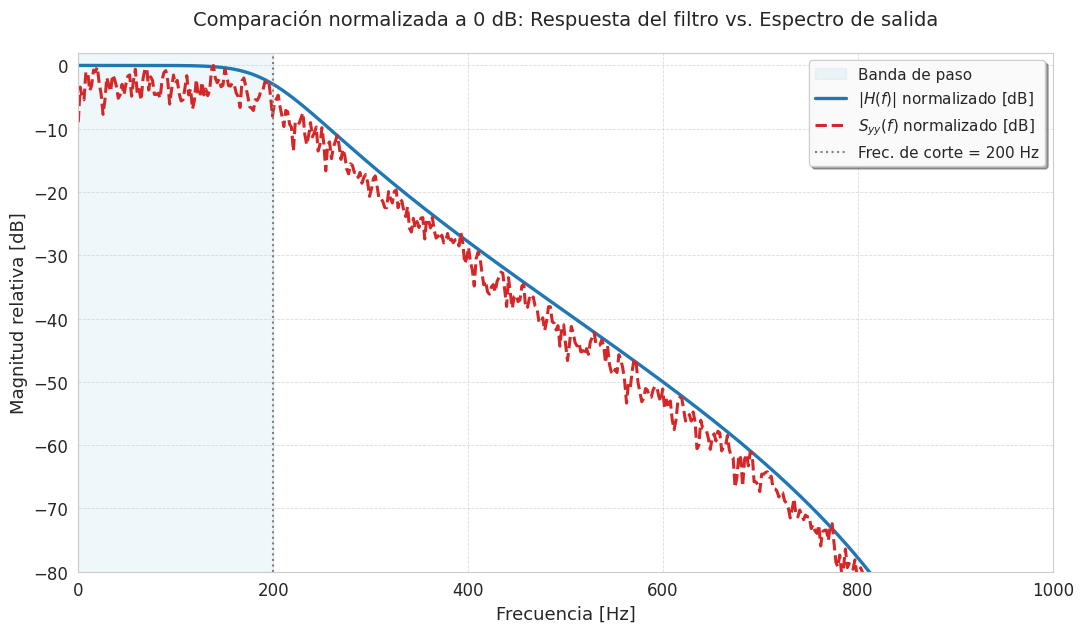

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns

# Estilo visual atractivo
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11,
    "figure.titlesize": 16,
    "grid.alpha": 0.4
})

# ----------------------------
# Parámetros
# ----------------------------
fs = 2000          # Frecuencia de muestreo (Hz)
T = 2.0            # Duración (s)
N = int(fs * T)

# ----------------------------
# 1. Señal de entrada: ruido blanco gaussiano
# ----------------------------
np.random.seed(42)
x = np.random.randn(N)

# Estimar PSD de la entrada usando Welch
f, S_xx = signal.welch(x, fs=fs, nperseg=1024, scaling='density')

# ----------------------------
# 2. Filtro SLIT: Butterworth paso bajo
# ----------------------------
fc = 200  # Frecuencia de corte (Hz)
order = 4
b, a = signal.butter(order, fc, fs=fs, btype='low')

# Respuesta en frecuencia del filtro
w, H = signal.freqz(b, a, worN=len(f), fs=fs)

# ----------------------------
# 3. Calcular S_yy(f) = |H(f)|² * S_xx(f)
# ----------------------------
S_yy = (np.abs(H) ** 2) * S_xx

# ----------------------------
# 4. Convertir a dB y normalizar a 0 dB
# ----------------------------
eps = 1e-15
H_mag_db = 20 * np.log10(np.abs(H) + eps)
S_yy_db = 10 * np.log10(S_yy + eps)

H_mag_db_norm = H_mag_db - np.max(H_mag_db)
S_yy_db_norm = S_yy_db - np.max(S_yy_db)

# ----------------------------
# 5. Graficar con estilo mejorado
# ----------------------------
plt.figure(figsize=(11, 6.5))

# Sombra de la banda de paso (opcional pero útil)
plt.axvspan(0, fc, color='lightblue', alpha=0.2, label='Banda de paso')

# Curvas principales
plt.plot(f, H_mag_db_norm, color='#1f77b4', linewidth=2.4, label=r'$|H(f)|$ normalizado [dB]')
plt.plot(f, S_yy_db_norm, color='#d62728', linestyle='--', linewidth=2.2, label=r'$S_{yy}(f)$ normalizado [dB]')

# Línea de corte
plt.axvline(fc, color='gray', linestyle=':', linewidth=1.5, label=f'Frec. de corte = {fc} Hz')

# Etiquetas y estilo
plt.title('Comparación normalizada a 0 dB: Respuesta del filtro vs. Espectro de salida', pad=20)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud relativa [dB]')
plt.xlim(0, fs/2)
plt.ylim(-80, 2)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, framealpha=0.95)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

# Ajustar layout
plt.tight_layout()
plt.show()

# 🔬 Mathematical Analysis of Audio Quantization: Uniform vs. μ-law

This notebook analyzes the effects of **uniform** and **μ-law** quantization on audio signals, with a focus on:
- Signal representation.
- Quantization error.
- Voice-band filtering.
- Power spectral density (PSD).

We use a real audio file (`Audio_nouse_full (1).mp3`) and apply 8-bit quantization (256 levels) to compare performance.

---

## 🧮 1. Signal Model

Let $ y(t) \in [-1, 1] $ be the original audio signal sampled at rate $ f_s $. We assume:
- $ y(t) $ is continuous-time but discretized as $ y[n] $, $ n = 0, 1, \dots, N-1 $.
- The signal is normalized such that $ \max |y[n]| = 1 $.

---

## 🎯 2. Quantization Methods

Quantization maps a continuous range $[-1, 1]$ to a finite set of discrete levels. We consider two methods:

### 2.1 Uniform Quantization

Uniform quantization divides the interval $[-1, 1]$ into $ L = 2^b $ equal intervals, where $ b = 8 $ bits → $ L = 256 $.

#### Steps:
1. **Scale**: Map $ y[n] $ to $[0, L-1]$:
   $$
   x_{\text{scaled}}[n] = \frac{y[n] + 1}{2} \cdot (L - 1)
   $$
2. **Round**: Quantize to nearest integer:
   $$
   q[n] = \text{round}(x_{\text{scaled}}[n])
   $$
3. **Clip**: Ensure values are within bounds:
   $$
   q[n] = \min(\max(q[n], 0), L - 1)
   $$
4. **Reconstruct**: Scale back to $[-1, 1]$:
   $$
   y_{\text{uni}}[n] = \frac{q[n]}{L - 1} \cdot 2 - 1
   $$

#### Error:
The quantization error $ e_{\text{uni}}[n] = y[n] - y_{\text{uni}}[n] $ is uniformly distributed over $[- \Delta/2, \Delta/2]$, where $ \Delta = \frac{2}{L-1} $.

---

### 2.2 μ-law (A-law) Non-uniform Quantization

μ-law compresses large-amplitude signals and expands small ones, improving resolution for low-level signals (e.g., speech).

#### Compression:
$$
x_c[n] = \text{sign}(y[n]) \cdot \frac{\ln(1 + \mu |y[n]|)}{\ln(1 + \mu)}
$$
where $ \mu = 255 $ is the compression parameter.

#### Quantization:
Same as uniform:  
$$
q[n] = \text{round}\left( \frac{x_c[n] + 1}{2} \cdot (L - 1) \right)
$$

#### Expansion:
$$
y_{\mu}[n] = \text{sign}(q[n]) \cdot \frac{(1 + \mu)^{|q[n]|/(L-1)} - 1}{\mu}
$$

> **Note**: This method preserves dynamic range better for speech.

---

## 🔊 3. Voice Band Filtering (300–3400 Hz)

Human speech occupies the **voice band** $ [300, 3400] $ Hz. We apply a bandpass filter to isolate this region.

### Filter Design:
Use a **6th-order Butterworth filter**:
$$
H(s) = \frac{1}{(s^2 + a_1 s + b_1)(s^2 + a_2 s + b_2)(s^2 + a_3 s + b_3)}
$$
with cutoff frequencies $ f_l = 300 $ Hz, $ f_h = 3400 $ Hz.

In digital domain (IIR):
$$
\text{SOS} = \text{butter}(order=6, Wn=[300, 3400], btype='band', fs=f_s, output='sos')
$$

### Purpose:
- Remove noise outside speech band.
- Focus analysis on relevant frequency content.

---

## 📈 4. Power Spectral Density (PSD)

PSD measures power per unit frequency. We use Welch’s method:
$$
P_{xx}(f) = \frac{1}{N} \left| \sum_{k=0}^{N-1} x[k] w[k] e^{-j 2\pi f k / f_s} \right|^2
$$
where $ w[k] $ is a window function (Hann by default).

### Units:
- $ P_{xx}(f) $ in $ \text{W/Hz} $.
- Convert to dB: $ 10 \log_{10}(P_{xx}(f)) $.

---

## 🧪 5. Quantization Error Analysis

We compute:
- **Mean Squared Error (MSE)**:
  $$
  \text{MSE} = \frac{1}{N} \sum_{n=0}^{N-1} (y[n] - y_q[n])^2
  $$
- **Signal-to-Noise Ratio (SNR)**:
  $$
  \text{SNR} = 10 \log_{10} \left( \frac{\text{Power of } y}{\text{Power of } e} \right)
  $$
- **Peak Signal-to-Noise Ratio (PSNR)**:
  $$
  \text{PSNR} = 10 \log_{10} \left( \frac{1}{\text{MSE}} \right)
  $$

---

## 📊 6. Visualization Strategy

We plot:
1. **Time-domain**: Original vs. quantized signals (zoomed).
2. **Level distribution**: Scatter plots of quantized values.
3. **PSD**: After voice filtering.
4. **Audio playback**: For subjective comparison.

---


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Audio cargado desde: /content/Audio_nouse_full (1).mp3
✅ Loaded: 330865 samples @ 44100 Hz


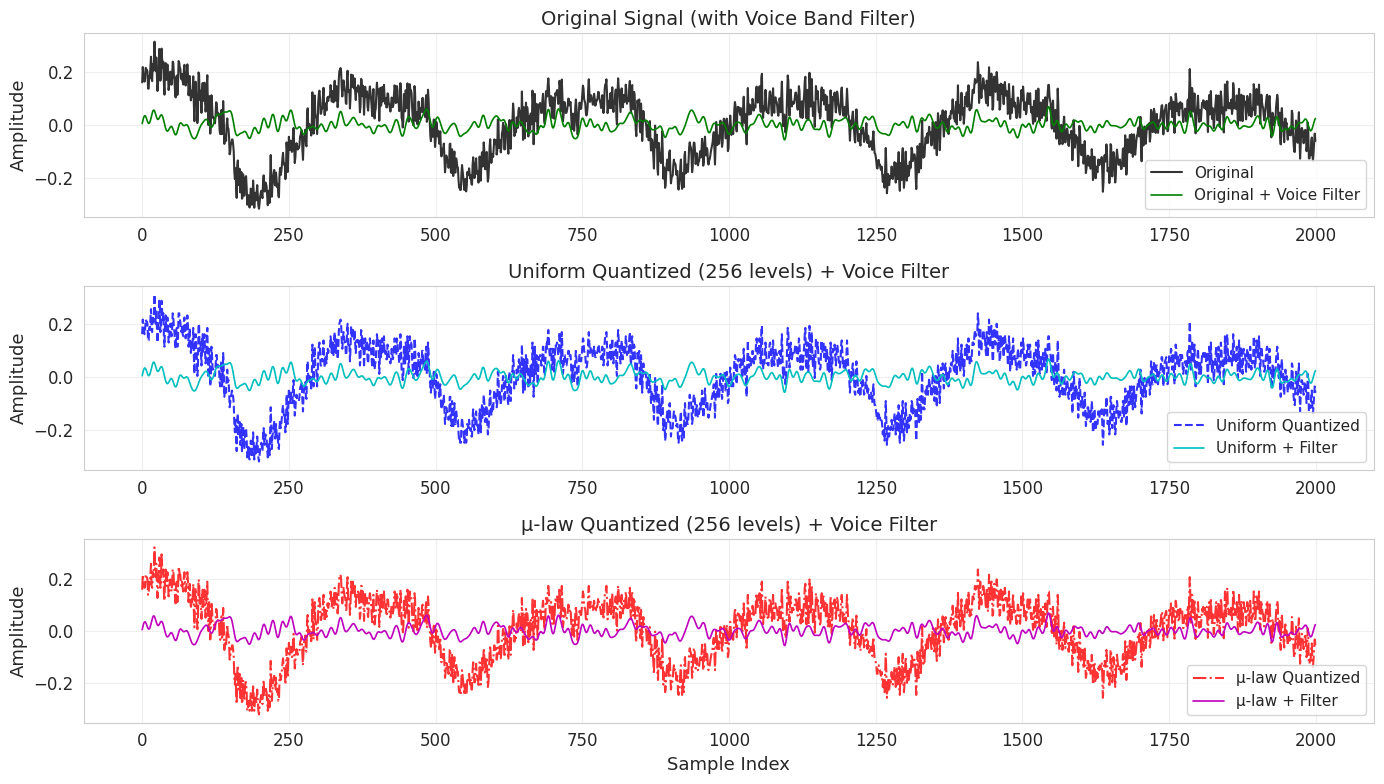

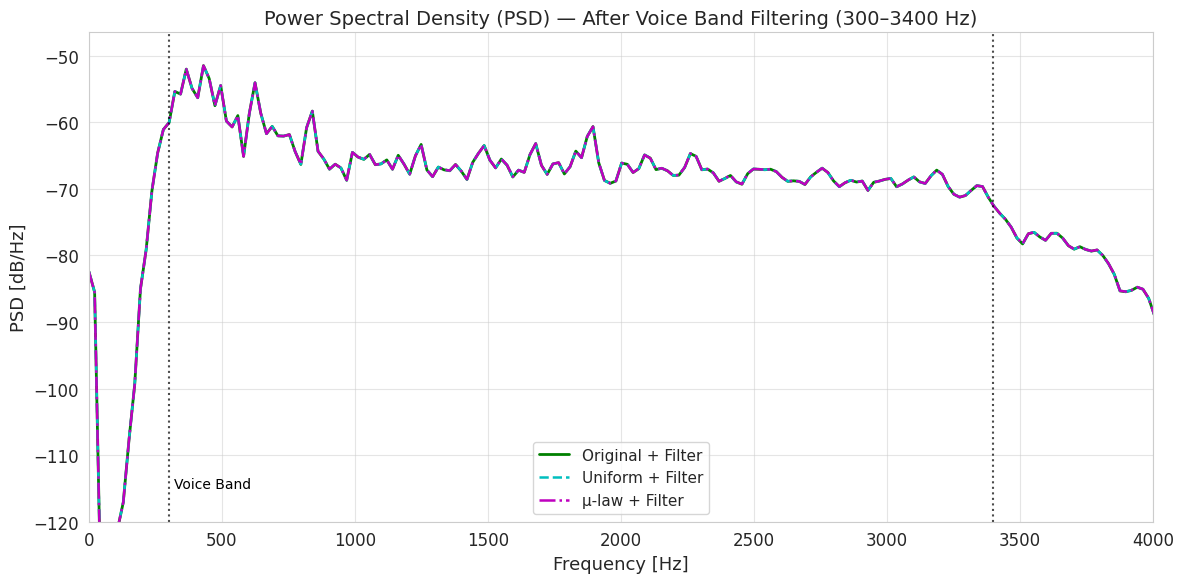


🔊 Listen to filtered signals (voice band only):
1. Original + Voice Filter:


2. Uniform Quantized + Voice Filter:


3. μ-law Quantized + Voice Filter:


In [ ]:
# Install required packages (if not already installed)
try:
    import librosa
except ImportError:
    !pip install librosa

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from google.colab import files
import IPython.display as ipd

# ----------------------------
# 1. Upload & Load Audio
# ----------------------------
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta del archivo en tu Drive
audio_path = '/content/Audio_nouse_full (1).mp3'

# Verificar que el archivo existe
import os
if not os.path.exists(audio_path):
    raise FileNotFoundError(f"Archivo no encontrado: {audio_path}")

print(f"Audio cargado desde: {audio_path}")

# Load as mono, preserve original sample rate
y, sr = librosa.load(audio_path, sr=None, mono=True)
print(f"✅ Loaded: {len(y)} samples @ {sr} Hz")

# Normalize to [-1, 1]
y = y / np.max(np.abs(y) + 1e-9)

# ----------------------------
# 2. Quantization (256 levels = 8-bit)
# ----------------------------
n_bits = 8
n_levels = 2**n_bits

def uniform_quantize(x, L):
    x_q = np.round((x + 1) / 2 * (L - 1))
    x_q = np.clip(x_q, 0, L - 1)
    x_rec = (x_q / (L - 1)) * 2 - 1
    return x_rec.astype(np.float32)

def mu_law_quantize(x, L, mu=255):
    # Compress
    x_c = np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)
    # Uniform quantize compressed signal
    x_q = np.round((x_c + 1) / 2 * (L - 1))
    x_q = np.clip(x_q, 0, L - 1)
    # Expand
    x_rec = (x_q / (L - 1)) * 2 - 1
    x_rec = np.sign(x_rec) * (1/mu) * ((1 + mu)**np.abs(x_rec) - 1)
    return x_rec.astype(np.float32)

# Apply quantization
y_uniform = uniform_quantize(y, n_levels)
y_mu = mu_law_quantize(y, n_levels)

# ----------------------------
# 3. Voice Bandpass Filter (300–3400 Hz)
# ----------------------------
def design_voice_filter(sr, low=300, high=3400, order=6):
    nyq = sr / 2
    sos = signal.butter(order, [low, high], btype='band', fs=sr, output='sos')
    return sos

sos_voice = design_voice_filter(sr)

# Filter all three versions
y_filt = signal.sosfiltfilt(sos_voice, y)
y_uniform_filt = signal.sosfiltfilt(sos_voice, y_uniform)
y_mu_filt = signal.sosfiltfilt(sos_voice, y_mu)

# ----------------------------
# 4. Plot Time-Domain Comparison (short segment)
# ----------------------------
n_plot = min(2000, len(y))

plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(y[:n_plot], 'k', label='Original', alpha=0.8)
plt.plot(y_filt[:n_plot], 'g', linewidth=1.2, label='Original + Voice Filter')
plt.title('Original Signal (with Voice Band Filter)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(y_uniform[:n_plot], 'b--', label='Uniform Quantized', alpha=0.8)
plt.plot(y_uniform_filt[:n_plot], 'c', linewidth=1.2, label='Uniform + Filter')
plt.title('Uniform Quantized (256 levels) + Voice Filter')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(y_mu[:n_plot], 'r-.', label='μ-law Quantized', alpha=0.8)
plt.plot(y_mu_filt[:n_plot], 'm', linewidth=1.2, label='μ-law + Filter')
plt.title('μ-law Quantized (256 levels) + Voice Filter')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# 5. Frequency Domain: PSD Comparison (Filtered Signals)
# ----------------------------
f_orig, Pxx_orig = signal.welch(y_filt, fs=sr, nperseg=2048)
f_uni, Pxx_uni = signal.welch(y_uniform_filt, fs=sr, nperseg=2048)
f_mu, Pxx_mu = signal.welch(y_mu_filt, fs=sr, nperseg=2048)

Pxx_orig_db = 10 * np.log10(Pxx_orig + 1e-15)
Pxx_uni_db = 10 * np.log10(Pxx_uni + 1e-15)
Pxx_mu_db = 10 * np.log10(Pxx_mu + 1e-15)

plt.figure(figsize=(12, 6))
plt.plot(f_orig, Pxx_orig_db, 'g', linewidth=2, label='Original + Filter')
plt.plot(f_uni, Pxx_uni_db, 'c--', linewidth=1.8, label='Uniform + Filter')
plt.plot(f_mu, Pxx_mu_db, 'm-.', linewidth=1.8, label='μ-law + Filter')

plt.title('Power Spectral Density (PSD) — After Voice Band Filtering (300–3400 Hz)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.xlim(0, 4000)
plt.ylim(-120, np.max(Pxx_orig_db) + 5)
plt.axvline(300, color='k', linestyle=':', alpha=0.7)
plt.axvline(3400, color='k', linestyle=':', alpha=0.7)
plt.text(320, plt.ylim()[0] + 5, 'Voice Band', color='k', fontsize=10)
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# ----------------------------
# 6. Audio Playback (Filtered Versions)
# ----------------------------
print("\n🔊 Listen to filtered signals (voice band only):")
print("1. Original + Voice Filter:")
ipd.display(ipd.Audio(y_filt, rate=sr))

print("2. Uniform Quantized + Voice Filter:")
ipd.display(ipd.Audio(y_uniform_filt, rate=sr))

print("3. μ-law Quantized + Voice Filter:")
ipd.display(ipd.Audio(y_mu_filt, rate=sr))

/tmp/ipython-input-4163342228.py:39: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4163342228.py:39: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


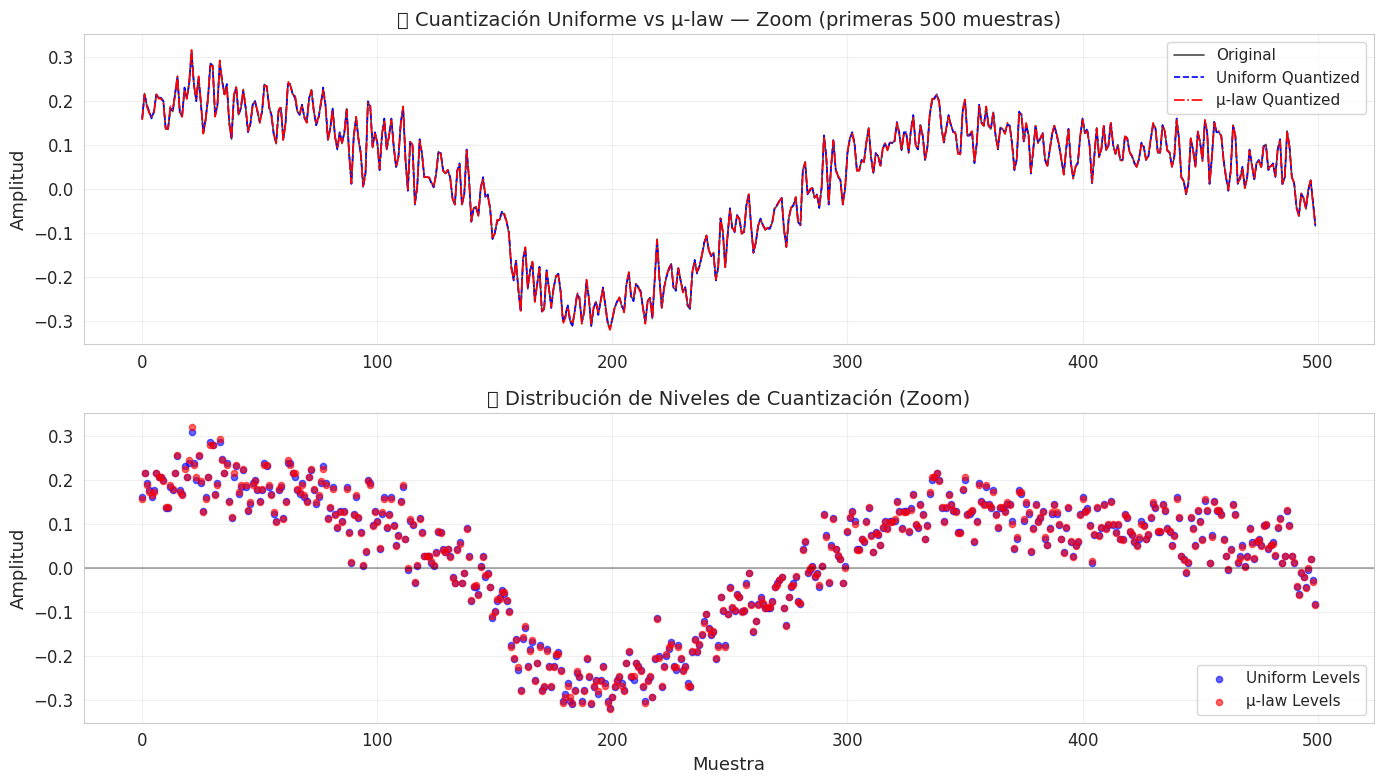


📊 Análisis de niveles de cuantización:
→ Niveles únicos en cuantización uniforme: 77
→ Niveles únicos en cuantización μ-law: 131

🔹 Primeros niveles (uniform): [-0.31764704 -0.3098039  -0.30196077 -0.29411763 -0.2862745  -0.27843136
 -0.27058822 -0.26274508 -0.25490195 -0.24705881]
🔹 Primeros niveles (μ-law): [-0.32012522 -0.306334   -0.29312968 -0.28048736 -0.2683831  -0.25679398
 -0.24569808 -0.23507442 -0.2249029  -0.21516427]


/tmp/ipython-input-4163342228.py:60: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


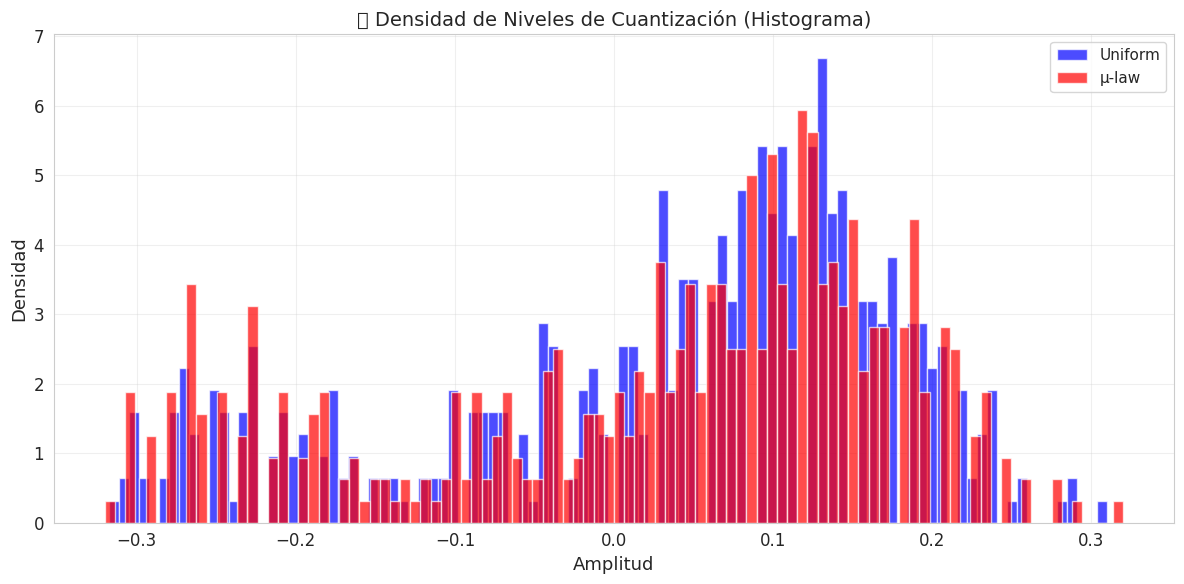

In [ ]:
# --- Visualización de niveles de cuantización (zoom en primeros 500 muestras) ---
n_zoom = 500  # Muestras a mostrar
x = np.arange(n_zoom)

# --- Preparar datos para el plot ---
y_zoom = y[:n_zoom]
y_uniform_zoom = y_uniform[:n_zoom]
y_mu_zoom = y_mu[:n_zoom]

# --- Generar los niveles únicos de cuantización ---
levels_uniform = np.unique(y_uniform_zoom)
levels_mu = np.unique(y_mu_zoom)

# --- Crear el gráfico ---
plt.figure(figsize=(14, 8))

# Gráfico principal: Señal original + cuantizadas
plt.subplot(2, 1, 1)
plt.plot(x, y_zoom, 'k', alpha=0.7, linewidth=1.2, label='Original')
plt.plot(x, y_uniform_zoom, 'b--', linewidth=1.2, label='Uniform Quantized')
plt.plot(x, y_mu_zoom, 'r-.', linewidth=1.2, label='μ-law Quantized')
plt.title('🔍 Cuantización Uniforme vs μ-law — Zoom (primeras 500 muestras)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Gráfico secundario: Distribución de niveles de cuantización
plt.subplot(2, 1, 2)
plt.scatter(x, y_uniform_zoom, c='blue', s=20, alpha=0.6, label='Uniform Levels')
plt.scatter(x, y_mu_zoom, c='red', s=20, alpha=0.6, label='μ-law Levels')
plt.axhline(0, color='k', linestyle='-', alpha=0.3)
plt.title('🎯 Distribución de Niveles de Cuantización (Zoom)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Ajustar espaciado
plt.tight_layout()
plt.show()

# --- Análisis adicional: Histograma de niveles únicos ---
print(f"\n📊 Análisis de niveles de cuantización:")
print(f"→ Niveles únicos en cuantización uniforme: {len(levels_uniform)}")
print(f"→ Niveles únicos en cuantización μ-law: {len(levels_mu)}")

# Mostrar los niveles más cercanos a 0 (ejemplo)
print(f"\n🔹 Primeros niveles (uniform): {np.sort(levels_uniform)[:10]}")
print(f"🔹 Primeros niveles (μ-law): {np.sort(levels_mu)[:10]}")

# --- Comparación visual de densidad de niveles ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(y_uniform_zoom, bins=100, alpha=0.7, color='blue', density=True, label='Uniform')
ax.hist(y_mu_zoom, bins=100, alpha=0.7, color='red', density=True, label='μ-law')
ax.set_title('📈 Densidad de Niveles de Cuantización (Histograma)')
ax.set_xlabel('Amplitud')
ax.set_ylabel('Densidad')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()